In [1]:
# This code study kinematic profile of MW, M31 merger remenant,
# by calculates velocity dispersion and rotation curve. 


# Type 1 = Dark Matter, Type 2 = Disk Stars, Type3 = Bulge Stars

In [9]:
# import all modules needed 
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from Lab7 import RotateFrame, density_contour

from scipy.stats import binned_statistic
import matplotlib.pyplot as plt

In [10]:
# combine those into single data set 
# numpy.concatenate() 
# https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html 
class Remnant: 
    
    
    def __init__(self, Galaxy1 , Galaxy2, Snap): # create center of mass object for MW and M31, snapshot #560 corresponding 8.0 Gyrs from now
        """Initialize a remnant object. This will create an new text file with disk and buldge particles in merger remnant. 
        Parameters
        ---------
        Galaxy1 'string'
            name of galaxy 
        Gaalaxy2 'string'
            name of galaxy in merger
        snap 'int'
            snapshot number 
        """
        
        self.Snap = Snap 

        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(Snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        filename1 = "%s_"%(Galaxy1) + ilbl + '.txt'
        filename2 = "%s_"%(Galaxy2) + ilbl + '.txt'
        
        time1, total1, data1 = Read(filename1)  
        time2, total2, data2 = Read(filename2)  

        data = np.concatenate((data1, data2))
        index = np.where(data['type'] != 1 )

        self.remnants = data[index] 
        self.filename ="Remnant_" + ilbl + '.txt'

    #     change to calculate time 
        time = 7999.99999
        n_particles = len(self.remnants)

        with open(self.filename, 'w') as f:

            f.write(f"Time   {time:.5f}\n")
            f.write(f"Total       {n_particles}\n")
            f.write("mass in 1e10,  x, y, z, in kpc and vx, vy, vz in km/s\n")

            # Header line
            header = "{:>11s} {:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}".format(
                'type', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz')
            f.write(header + "\n")

            # Write each row with different formatting for 'm'
            for row in self.remnants:
                formatted_row = "{:11.0f} {:11.9f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}{:11.4f}".format(
                    row[0],  # type
                    row[1],  # m (mass) with 9 decimal places
                    row[2], row[3], row[4],  # x, y, z
                    row[5], row[6], row[7]   # vx, vy, vz
                )
                f.write(formatted_row + "\n")
                     
                     
    def V_circ(self):
        """Create rotation curve, circular velocity of all mass enclosed in given radius.
        """
        Rm = MassProfile("Remnant", self.Snap)
        rr = np.arange(0.01, 45, 0.1)

        # Circular Velocity Profile
        Vcirc = Rm.CircularVelocityTotal(rr)

        return rr, Vcirc
        
        
    def RotateAxis(self): 
        """a function that will rotate the position and velocity vectors
        so that the disk angular momentum is aligned with z axis. 
    
        PARAMETERS
        ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
        RETURNS
        -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) 
            such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) 
            such that disk angular momentum vector
            is in the +z direction 
        """
            # recalculate center of COM with Disk particles
        COMD = CenterOfMass(self.filename, 2)
        
        # Compute COM of remenent using disk particles
        COMP = COMD.COM_P(0.1)
        COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
        # print(f"Center of Mass : {COMP}")

        # Determine positions of disk particles relative to COM 
        xD = COMD.x - COMP[0].value 
        yD = COMD.y - COMP[1].value 
        zD = COMD.z - COMP[2].value 
        
        # total magnitude
        rtot = np.sqrt(xD**2 + yD**2 + zD**2)

        # Determine velocities of disk particles relatiev to COM motion
        vxD = COMD.vx - COMV[0].value 
        vyD = COMD.vy - COMV[1].value 
        vzD = COMD.vz - COMV[2].value 

        # total velocity 
        vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

        #Array for r and v
        r = np.array([xD,yD,zD]).T # transposed 
        v = np.array([vxD,vyD,vzD]).T

        self.rn, self.vn = RotateFrame(r, v)
    
    def EdgeOnVIew(self): 
        """a function to create an edge on view figure of remnant system. 
        """

        # M31 Disk Density 
        fig, ax= plt.subplots(figsize=(15, 10))

        # plot the particle density for M31 , 2D histogram
        # plt.hist2d(rn[:,0], rn[:,2], bins=900, norm=LogNorm(vmin=1), cmap='magma') # face-on 
        plt.hist2d(self.rn[:,0], self.rn[:,1], bins=900, norm=LogNorm(vmin=1), cmap='magma') # edge-on 

        # density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax, colors=['yellow', 'red','white', 'yellow'])
        
        cbar = plt.colorbar()
        cbar.set_label("Number of disk particle per bin", fontsize=15)
        
        # Add axis labels
        plt.xlabel('x (kpc)', fontsize=22)
        plt.ylabel('z (kpc)', fontsize=22)

        #set axis limits
        plt.ylim(-30,30)
        plt.xlim(-30,30)

        #adjust tick label font size
        label_size = 22
        matplotlib.rcParams['xtick.labelsize'] = label_size 
        matplotlib.rcParams['ytick.labelsize'] = label_size
        pdfname = "plot/EdgeOnView_%d"%self.Snap + ".png"
        plt.savefig(pdfname)

    def V_Phi(self): 
        """a function to calcurate a circular velocity in cylindical coordinate as a function of distance from the center of mass. 
        
        Output 
            rr_new : array of distnace r (kpc)
            v_phi : mean circular velocity (km/s)
        """
        # radius 
        rho = np.sqrt(self.rn[:,0]**2 + self.rn[:,1]**2) 

        # radial velocity 
        vr = (self.rn[:,0] * self.vn[:,0] + self.rn[:,1] * self.vn[:,1]) / rho

        # azimuthal velocity
        vphi = (self.rn[:,0] *  self.vn[:,1] - self.rn[:,1] * self.vn[:,0]) / rho
        
        # Determine the mean vphi per radius

        # Initialize Array for Radius 0-40 kpc
        r2 = np.arange(0,41,1)

        # Initialize Empty Array for Velocity 
        v2= np.zeros(np.size(r2))
        # compute the mean vphi in radial bins

        for i in r2:
            index = np.where((rho > i) & (rho < i+1)) # walking out in radial bins
            v2[i] = np.mean(np.abs(vphi[index])) # mean velocity
        
        return r2, v2, rho, vphi

    def Vmax_over_sigma(self, R_target, v_max):
        """
        Compute v_max / sigma for all particles within R_target.
        σ is computed as the standard deviation of azimuthal velocities.

        Parameters:
        -----------
        R_target : float
            Max cylindrical radius (kpc) for particle selection
        v_max : float
           maximum circular velocity 
           
        Outout
        --------
        v_max_over_sigma : float
            Ratio of v_max to velocity dispersion sigma
        """
        x, y = self.rn[:, 0], self.rn[:, 1]
        vx, vy = self.vn[:, 0], self.vn[:, 1]

        # Cylindrical radius
        R = np.sqrt(x**2 + y**2)

        v_phi = (x * vy - y * vx) / R

        # Select particles within R_target
        mask = np.where( R <= R_target )
        v_phi_cut = v_phi[mask]

        if len(v_phi_cut) < 5:
            return np.nan

        sigma = np.std(v_phi_cut)
        if sigma == 0:
            return np.nan

        return v_max / sigma


In [11]:
snapnumber = 560

MW_M31 = Remnant("MW","M31", snapnumber)
MW_M31.RotateAxis()


In [12]:
rr, Vcirc = MW_M31.V_circ()
r2, v2, rho, vphi = MW_M31.V_Phi()

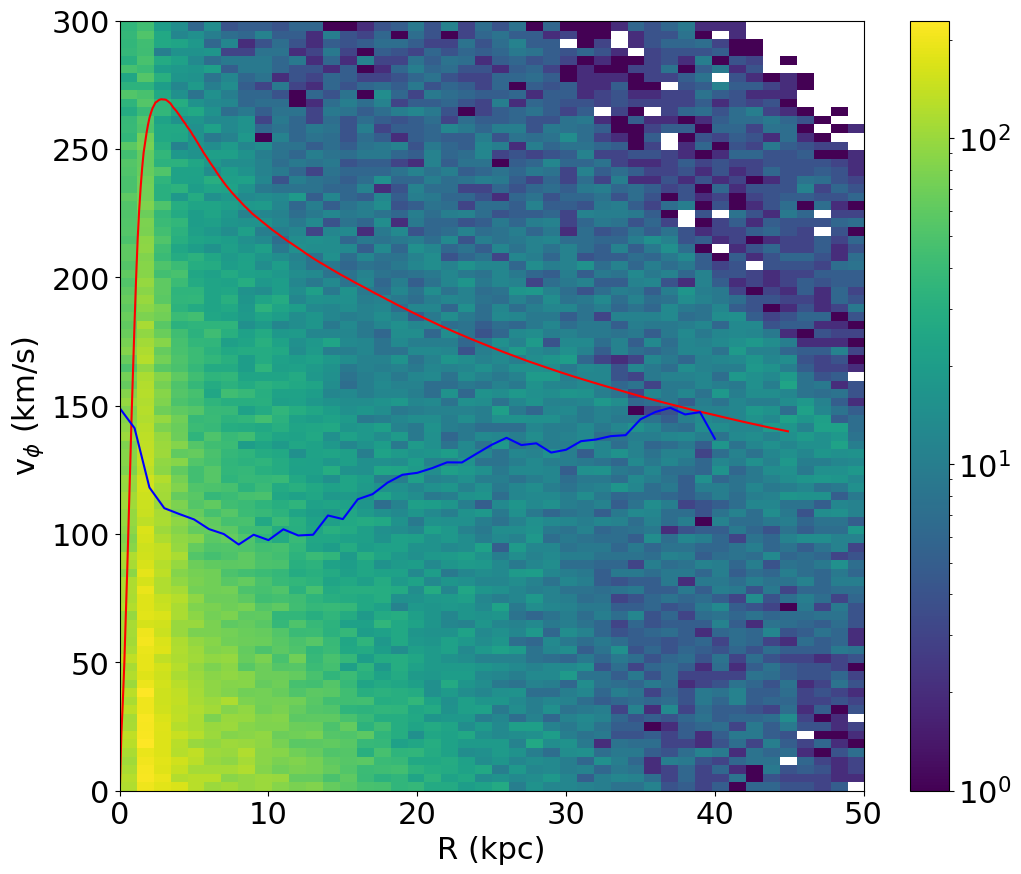

In [14]:

fig = plt.figure(figsize=(12,10))
ax = plt.subplot(111)

plt.hist2d(rho, np.abs(vphi), bins=200, norm=LogNorm())
# plt.scatter(rho, np.abs(vphi))
plt.colorbar()

# Add the circular velocity
plt.plot(rr, Vcirc, color="red", label="Circular Velocity")
#plt.plot(-r, -Vcirc, color="red")


# Add the v_phi
plt.plot(r2, v2, color="blue", label = "V_phi")
#plt.plot(-r2, -v2, color="blue")


# Add axis labels
plt.xlabel('R (kpc)', fontsize=22)
plt.ylabel(r'v$_\phi$ (km/s)', fontsize=22)

#set axis limits
plt.ylim(0, 300)
plt.xlim(0,50)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Save file
plt.savefig('plot/V%d.png'%snapnumber)